# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import xarray as xr

import toolbox_scs as tb
from toolbox_scs.routines.boz import load_dssc_module
from extra_data import open_run
from itertools import combinations
from itertools import repeat
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster

import pandas as pd
from datetime import date
from tqdm.notebook import tqdm
import matplotlib as mpl
plt.style.use('./zoey_style.mplstyle')

from os.path import basename, exists

from glob import glob
from pathlib import Path
from lmfit import Model, Parameters
from scipy.special import gamma, factorial, loggamma

# function definitions

In [2]:
def process_train(train, pulse_tol=0.05, mask=None, train_id=None, group_id=None, field=None, run=None, module=None, roi_id=None):
    # takes in a single train and returns an xarray dataset containing the photon statistics. No contrast calculation is done yet.
    # mask is assumed to be zeros everywhere and ones within the region of interest.
    # processing time on a single processor is ~15-30s
    
    # ravel pixels
    train = train.reshape(train.shape[0], -1)
    # remove negative values
    train = np.maximum(0, train)

    # initialize arrays to store outputs. nan values means that the pair has been filtered out
    # prob_all dimensions: (pulse separation x k photons x unique pairs) = 200 x 100 x 200
    # k_bar_all dimensions: (pulse separation x unique pairs) = 200 x 200
    # valid_pairs dimensions: (pulse separation) = 200
    prob_all = np.zeros((len(train), 100,  len(train)), dtype=float) * np.nan
    k_bar_all = np.zeros((len(train), len(train)), dtype=float) * np.nan
    valid_pairs = np.zeros(len(train), dtype=int)

    # loop over all iterations of pulse separations
    for i in tqdm(range(len(train)), total=len(train)):
        left_stack = train[:train.shape[0]-i]
        right_stack = train[i:]

        # ensure that both pulses have equal intensity. This is often not the case and heavily reduces the data.
        # I0 in this implementation is just the image sum without applying the mask
        filt = np.logical_and(np.nansum(left_stack, axis=-1)<=(1+pulse_tol)*np.nansum(right_stack, axis=-1), 
                                  np.nansum(right_stack, axis=-1)<=(1+pulse_tol)*np.nansum(left_stack, axis=-1))

        # Save the number points that were not filtered for future reference
        valid_pairs[i] = len(filt[filt==True])

        if mask is None:
            smd_left = left_stack[filt]
            smd_right = right_stack[filt]
        
        else:
            smd_left = left_stack[filt][..., mask.ravel()==1]
            smd_right = right_stack[filt][..., mask.ravel()==1]

        two_images = smd_left + smd_right

        # allow for a maximum of 100 photons in a single pixel. This is definitely overkill but 
        # should avoid any errors with shape later.
        prob_k = np.zeros((100, len(two_images)), dtype=float) 
        
        # iterate over all images that passed the intensity filter.
        # NOTE: the values are filled into the front of the array. The location within the train is not preserved.
        # This reduces the number of iterations needed significantly.
        two_images[two_images>99] = 99
        for ii, p in enumerate(two_images.astype(int)):
            counts = np.bincount(p)
            prob_k[:len(counts), ii] = counts / (len(p[~np.isnan(p)]))

        # Save the average number of photons in the images that passed the intensity filter.
        k_bar = np.nanmean(two_images, axis=(-1))

        # update output array with new values. shape will be the same across all trains.
        prob_all[i, :, :len(prob_k.T)] = prob_k
        k_bar_all[i, :len(k_bar)] = k_bar
       
    # combine data into xarray format that is consistent so it can be concatenated and saved later.
    ds = xr.Dataset(
        data_vars={'Pk': (('pulse_separation', 'k_photons', 'unique_pairs'), prob_all),
                  'k_bar': (('pulse_separation', 'unique_pairs'), k_bar_all),
                  'valid_pairs': (('count'), valid_pairs),
                   'train': train_id,
                   'group': group_id,
                   'roi': roi_id
                  },
        attrs={'run': run,
               'current': field,
               'module': module
              }
    )
    return ds

## metadata

In [22]:
current =    [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
runNB =      [70,  71,  73,  74,  76,  77,  79,  80,  82]
modules = [15, 0, 8, 7]
proposalNB = 2884

field = current[0]
run = runNB[0]
module = modules[1]
phi_index = 2

## initialize cluster

In [4]:
# partition = 'exfel'  # For EuXFEL staff
partition = 'upex'   # For users

cluster = SLURMCluster(
    queue=partition,
    local_directory='/scratch',  # Local disk space for workers to use
    log_directory='./logs',
    walltime=600,

    # Resources per SLURM job (per node, the way SLURM is configured on Maxwell)
    # processes=16 runs 16 Dask workers in a job, so each worker has 1 core & 32 GB RAM.
    processes=16, cores=16, memory='512GB',
)

# Get a notbook widget showing the cluster state
cluster

In [5]:
cluster.scale(64)

In [6]:
client = Client(cluster)
client

Client Scheduler: tcp://131.169.183.131:33511,Cluster Workers: 64 Cores: 64 Memory: 2.05 TB


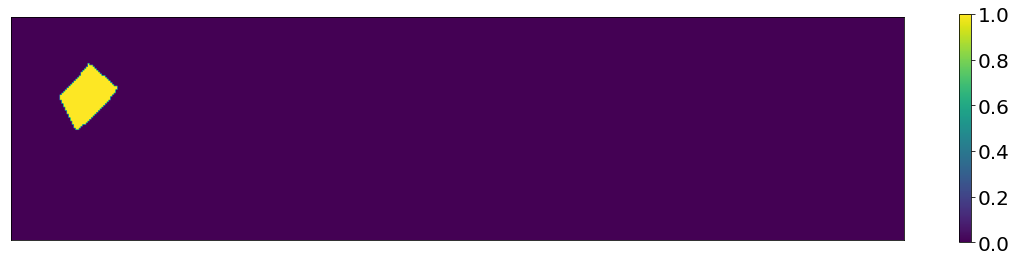

In [23]:
mask = np.load(f'./masks/run{run:0d}_module{module:1d}_mask.npy')
mask[mask!=phi_index] = 0
mask[mask==phi_index] = 1

plt.figure(figsize=(20,6))
plt.imshow(mask)
plt.colorbar(shrink=0.7)
plt.xticks([])
plt.yticks([])
plt.show()

In [20]:
%%time
group = 0

photon_maps = np.load(f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy')

CPU times: user 19.5 ms, sys: 7.85 s, total: 7.87 s
Wall time: 8.1 s


In [26]:
# Time to calculate statistics after everything is distributed is about 1:30 (same as time to distribute trains)
for group in tqdm(range(61), total=61, desc='group'): 
    out_file = rf'./calculated_statistics/run{run:0d}_module{module:0d}_group{group:1d}.h5'
    futures = []
    for train, mask_iter, tid in tqdm(zip(photon_maps, repeat(mask, len(photon_maps)), np.arange(len(photon_maps))), total=len(photon_maps), desc='distributing trains'):
        future = client.submit(process_train, train, mask=mask_iter, pulse_tol=0.05, train_id=tid,
                              group_id=group, field=field, run=run, module=module, roi_id=phi_index)
        futures.append(future)

    # progress doesn't work in for loop unfortunately
    #progress(futures)
    out = client.gather(futures)
    ds = xr.concat(out, dim='train')
    ds.to_netcdf(out_file, engine='h5netcdf')

group:   0%|          | 0/61 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
client.shutdown()